# Examen Segundo Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [1112]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Recursos Humanos

In [1113]:
df= pd.read_csv('hr_role.csv')

### Visualización del Dataset

In [1114]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


### Explicación de las variables

---

#### Se busca predecir si está satisfecho

In [1115]:
target= 'is_satisfied'

In [1116]:
len(df[df['is_satisfied'] == 1]), len(df[df['is_satisfied'] == 0])

(459, 1011)

Los datos están desbalanceados

In [1117]:
df.drop(['Over18','StandardHours'], axis=1, inplace=True)

#### Dummies

In [1118]:
df= pd.get_dummies(df, drop_first=True)

#### NaN's

In [1119]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ninguna Variable tiene NaN's , así que podemos continuar

#### Función Calibración 

In [1120]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

#### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

In [1121]:
X = df.drop(target, axis=1)
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Correlación

In [1122]:
# Compute the correlation of 'is_satisfied' with another column, for example, 'Age'
df.corr()['is_satisfied'].sort_values(ascending=False).head()

is_satisfied                    1.000000
EducationField_Life Sciences    0.044076
PercentSalaryHike               0.042461
Gender_Male                     0.040752
OverTime_Yes                    0.039452
Name: is_satisfied, dtype: float64

#### Feature Engineering

In [1123]:
numeric_features = [col for col in X.columns if X[col].dtype in ['float64']]
categorical_features = [col for col in X.columns if X[col].dtype not in ['float64']]

df['Tenure_ratio'] = df['YearsAtCompany'] * df['TotalWorkingYears']
df['Promotion_Frequency'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 1)


## **Modelos**

#### **KNN Clasificador**
---

In [1124]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param = {
    'knn__n_neighbors': np.arange(1,200), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}


##### - Random Search

In [1125]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param, n_iter=200, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)


random_search.best_params_
probabilidades_knn = random_search.predict_proba(X_test)[:, 1]

print(random_search.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': np.int64(36), 'knn__metric': 'euclidean'}


##### - Gridsearch

In [1126]:
grid_search = GridSearchCV(pipeline, param, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search.fit(X_train, y_train)

probabilidades_knn2 = grid_search.predict_proba(X_test)[:, 1]



#### **Regresión Logística**
---

In [1127]:
# Pipeline 
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
])

params_grid= {
    'poly__degree': [1, 2, 3],
    'logreg__C': ['l2', None],
    'logreg__C': [0.01,0.1,1]
}

##### RandomSearch


In [1128]:
log_reg_random= RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
log_reg_random.fit(X_train, y_train)

probabilidades_logisticarandom = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

##### - Gridsearch

In [1129]:
log_reg_grid= GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=5, n_jobs=-1, scoring='roc_auc')
log_reg_grid.fit(X_train, y_train)

probabilidades_logisticagrid = log_reg_grid.best_estimator_.predict_proba(X_test)[:,1]


#### **Red Neuronal**

---

In [1130]:
# Pipeline
pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])

params= {
    'nn__hidden_layer_sizes': [(100,100),(100,100,100)], 
    'nn__activation':['relu', 'tanh', 'logistic'],
    'nn__alpha': [0.01,0.1,1],
}

##### - RandomSearch

In [1131]:

neuro_random = RandomizedSearchCV(estimator=pipeline, param_distributions=params, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
neuro_random.fit(X_train, y_train)

probabilidades_neurorandom = neuro_random.best_estimator_.predict_proba(X_test)[:, 1]

##### - Gridsearch

In [1132]:
grid_neuro= GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_neuro.fit(X_train, y_train)
probabilidades_neurogrid = grid_neuro.best_estimator_.predict_proba(X_test)[:, 1]

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### **Analisis de Discriminante Lineal**
---

In [1133]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]

#### **Juntos**

In [1134]:
juntos = pd.DataFrame({
     'real': y_test,     
     'probabilidades_knn': probabilidades_knn,
     'probabilidades_knn2': probabilidades_knn2,
     'logisticarandom': probabilidades_logisticarandom,
     'logisticagrid': probabilidades_logisticagrid,
     'NeuroRandom': probabilidades_neurorandom,
     'NeuroGrid': probabilidades_neurogrid,
     'probabilidades_disc': probabilidades_modelo_disc

})

juntos.head()

,real,probabilidades_knn,probabilidades_knn2,logisticarandom,logisticagrid,NeuroRandom,NeuroGrid,probabilidades_disc
515,False,0.371824,0.324873,0.539904,0.539904,0.408973,0.375235,0.335046
306,False,0.373464,0.365482,0.342291,0.342291,0.452168,0.475112,0.428238
1255,False,0.449725,0.345178,0.218189,0.218189,0.353279,0.303977,0.329757
378,True,0.353284,0.314721,0.010553,0.010553,0.205624,0.167243,0.167808
332,False,0.327086,0.309645,0.090956,0.090956,0.397708,0.348189,0.358524


In [1135]:
# Bins
bins = 5
juntos['bins_log1'] = pd.qcut(juntos['logisticarandom'], bins, labels=False) + 1
juntos['bins_log2'] = pd.qcut(juntos['logisticagrid'], bins, labels=False) + 1

juntos['bins_knn1'] = pd.qcut(juntos['probabilidades_knn'], bins, labels=False) + 1
juntos['bins_knn2'] = pd.qcut(juntos['probabilidades_knn2'], bins, labels=False) + 1
juntos['bins_neuralrand'] = pd.qcut(juntos['NeuroRandom'], bins, labels=False) + 1
juntos['bins_neuralgrid'] = pd.qcut(juntos['NeuroGrid'], bins, labels=False) + 1
juntos['bins_disc'] = pd.qcut(juntos['probabilidades_disc'], bins, labels=False) + 1




# Agrupaciones
grouped_log1 = juntos.groupby('bins_log1').mean()
grouped_log2 = juntos.groupby('bins_log2').mean()
grouped_knn1 = juntos.groupby('bins_knn1').mean()
grouped_knn2 = juntos.groupby('bins_knn2').mean()
grouped_neuralrand = juntos.groupby('bins_neuralrand').mean()
grouped_neuralgrid = juntos.groupby('bins_neuralgrid').mean()
grouped_disc = juntos.groupby('bins_disc').mean()


## **Histograma, Calibración, roc AUC y AUC por modelo**

#### **KNN Clasificador**
---



##### - RandomSearch

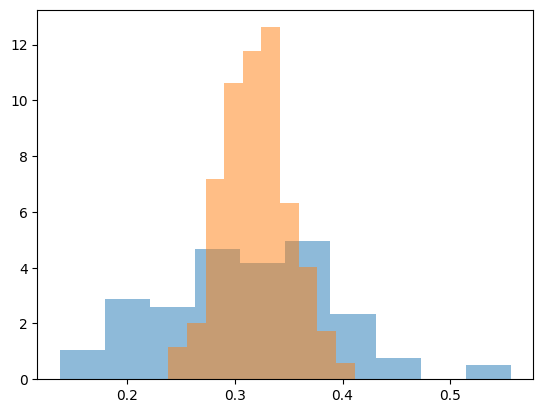

In [1136]:
plt.hist(juntos[juntos.real == 1].probabilidades_knn, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_knn2, density=True, alpha=0.5, bins=10)
plt.show()

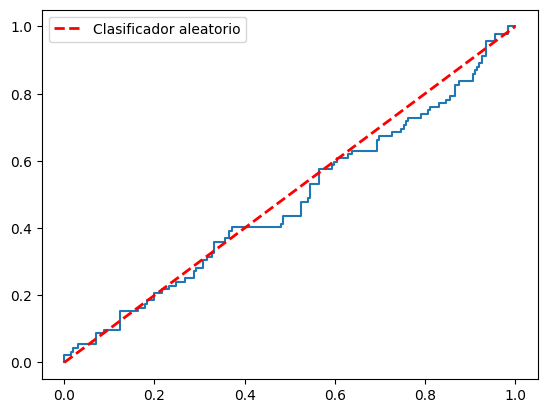

In [1137]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


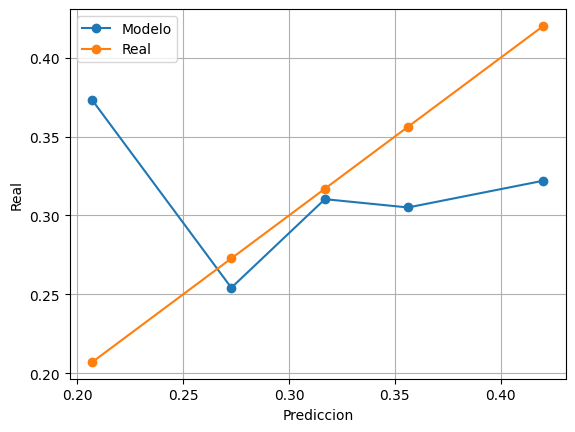

In [1138]:
calibracion(probabilidades_knn, y_test, 5)

In [1139]:
print('AUC RandomSearch: ',roc_auc_score(y_true=y_test,y_score= probabilidades_knn ))

AUC RandomSearch:  0.47809944037882046


##### - Gridsearch

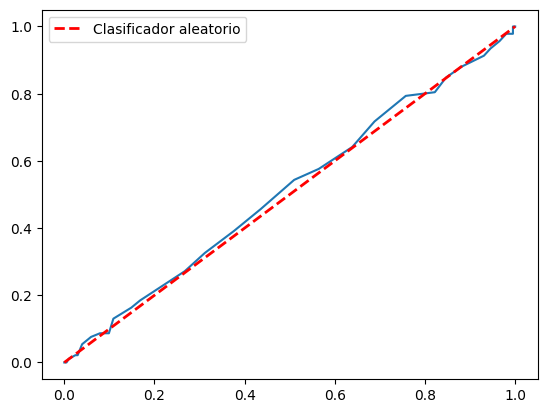

In [1140]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn2, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


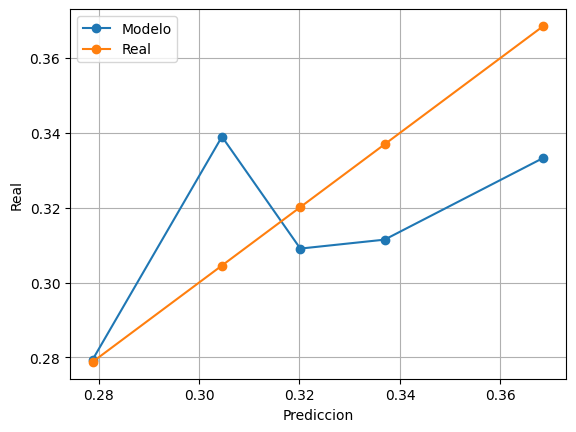

In [1141]:
calibracion(probabilidades_knn2, y_test, 5)

In [1142]:
print('AUC Gridsearch: ',roc_auc_score( y_true=y_test, y_score= probabilidades_knn2))

AUC Gridsearch:  0.5111924235901851


#### **Regresión Logistica**

---

##### - RandomSearch

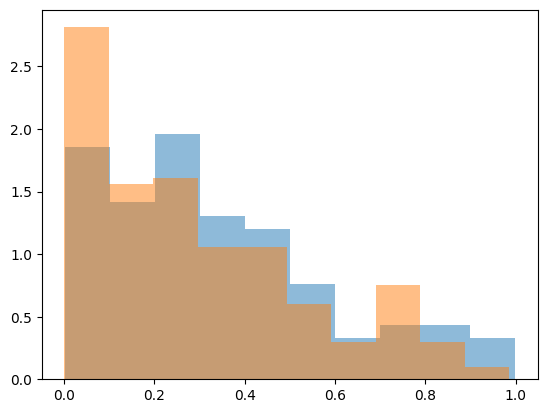

In [1143]:
plt.hist(juntos[juntos.real == 1].logisticarandom, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logisticarandom, density=True, alpha=0.5, bins=10)
plt.show()

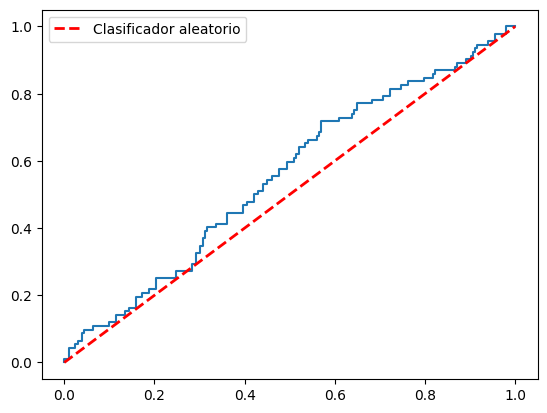

In [1144]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_logisticarandom, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


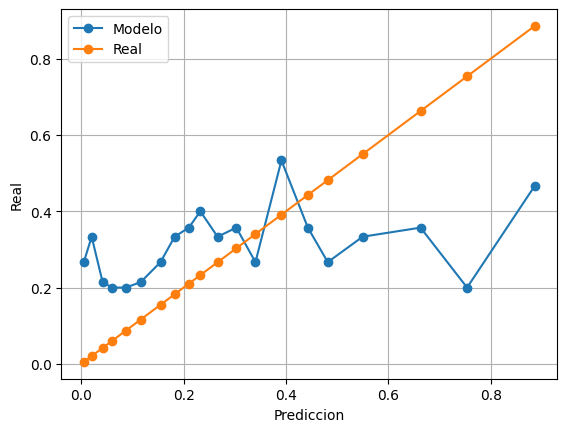

In [1145]:
calibracion(probabilidades_logisticarandom, y_test, 20)

In [1146]:
print('AUC: ',roc_auc_score(y_score= probabilidades_logisticarandom, y_true=y_test))

AUC:  0.5537559190701679


##### - Gridsearch

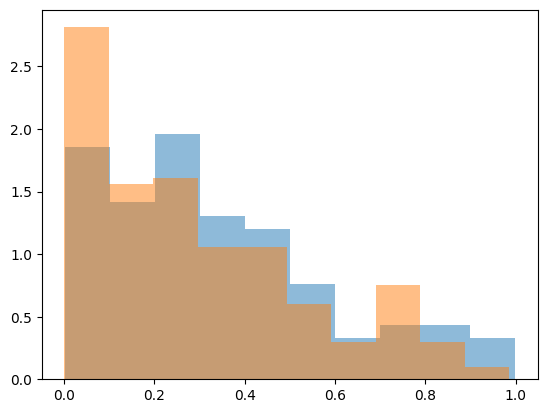

In [1147]:
plt.hist(juntos[juntos.real == 1].logisticagrid, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logisticagrid, density=True, alpha=0.5, bins=10)
plt.show()

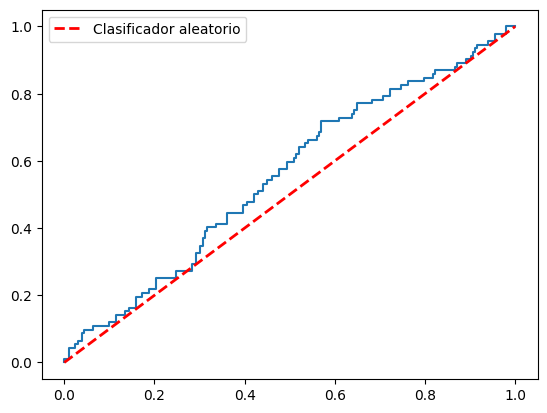

In [1148]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_logisticagrid, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


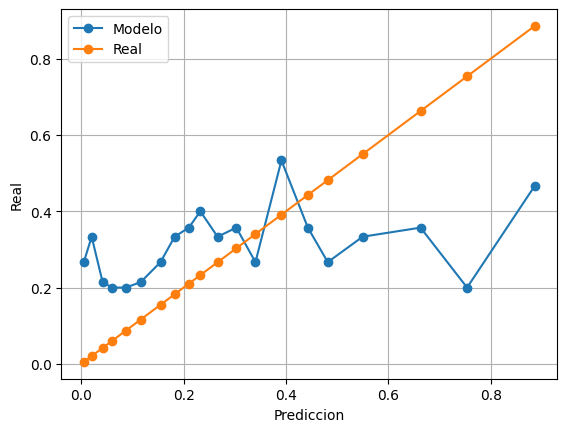

In [1149]:
calibracion(probabilidades_logisticagrid, y_test, 20)

In [1150]:
print('AUC: ',roc_auc_score(y_score= probabilidades_logisticagrid, y_true=y_test))

AUC:  0.5537559190701679


#### **Red Neuronal**
---

##### - RandomSearch

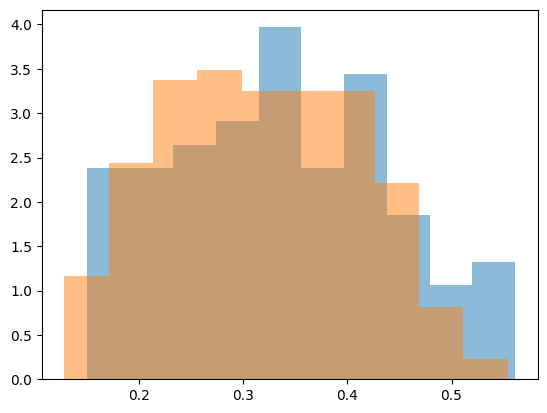

In [1151]:
plt.hist(juntos[juntos.real == 1].NeuroRandom, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].NeuroRandom, density=True, alpha=0.5, bins=10)
plt.show()

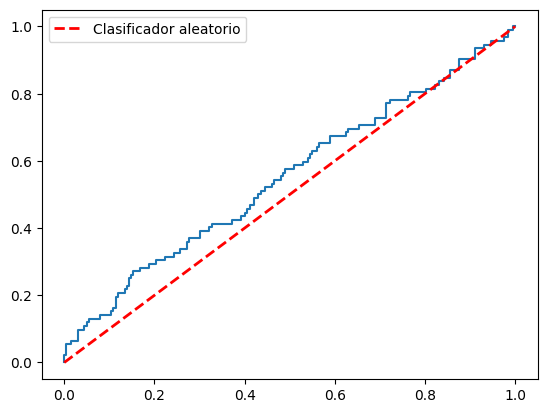

In [1152]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_neurorandom, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

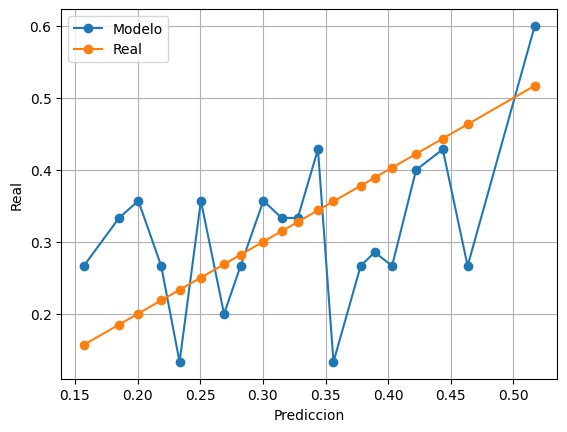

In [1153]:
calibracion(probabilidades_neurorandom, y_test, 20)

In [1154]:
print('AUC RandomSearch:', roc_auc_score(y_score=probabilidades_neurorandom, y_true=y_test))

AUC RandomSearch: 0.5510654326302196


##### - Gridsearch

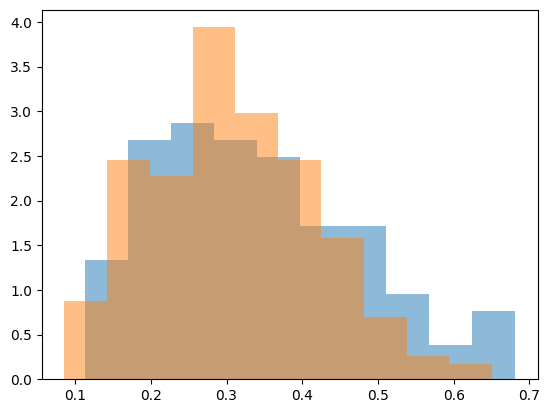

In [1155]:
plt.hist(juntos[juntos.real == 1].NeuroGrid, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].NeuroGrid, density=True, alpha=0.5, bins=10)
plt.show()

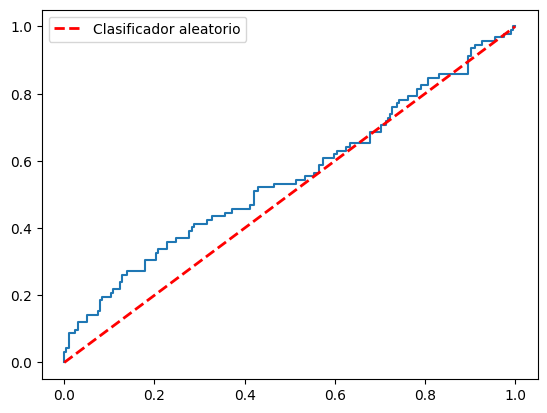

In [1156]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_neurogrid, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

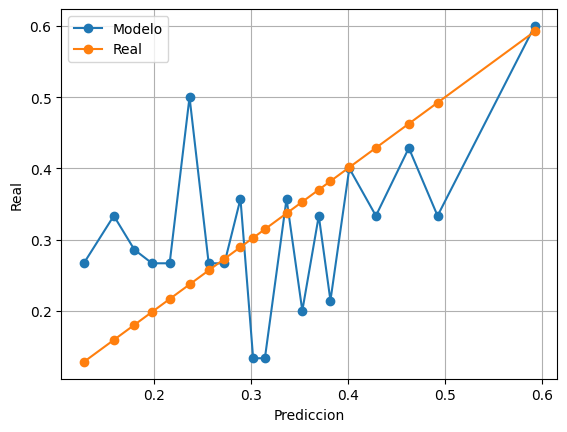

In [1157]:
calibracion(probabilidades_neurogrid, y_test, 20)

In [1158]:
print('AUC Gridsearch:', roc_auc_score(y_score=probabilidades_neurogrid, y_true=y_test))

AUC Gridsearch: 0.5512268618166164


##### **Discriminante Lineal**

---

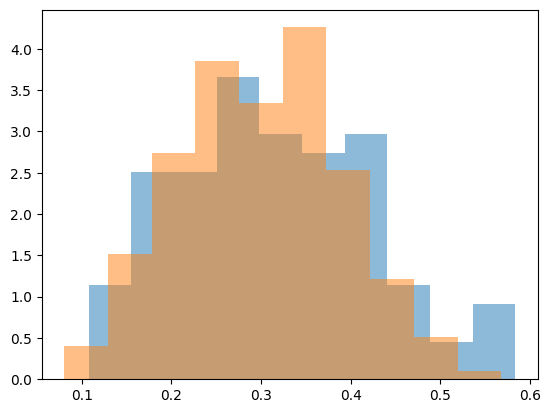

In [1159]:
plt.hist(juntos[juntos.real == 1].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.show()

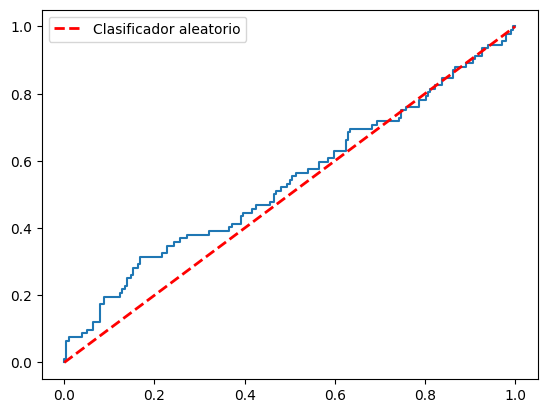

In [1160]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

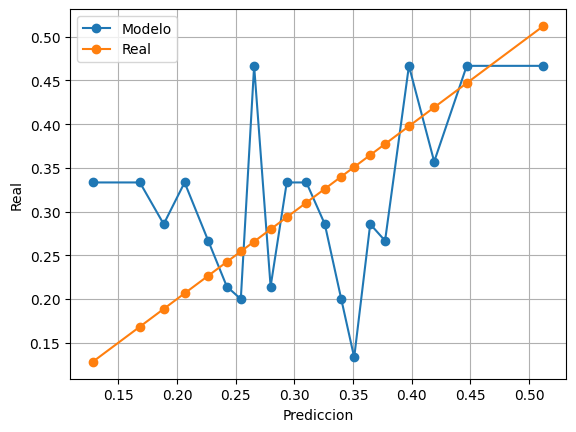

In [1161]:
calibracion(probabilidades_modelo_disc, y_test, 20)

In [1162]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo_disc, y_true=y_test))

AUC:  0.5391196728368489


##### Juntos

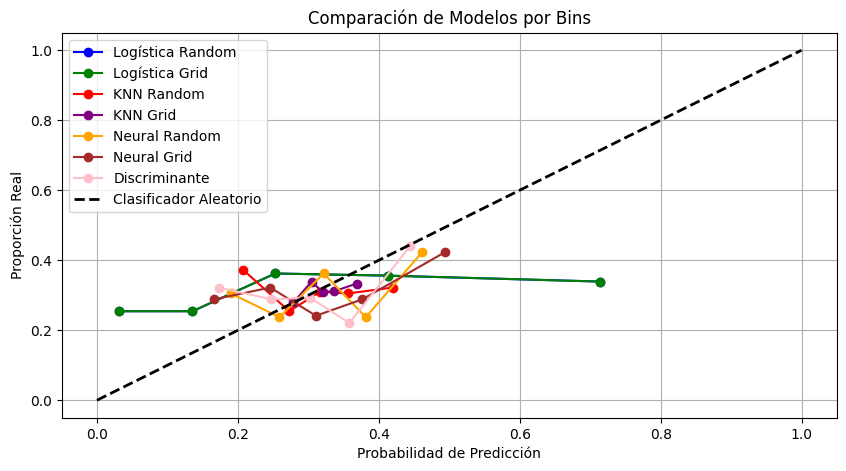

In [1163]:
import matplotlib.pyplot as plt

# Definir los colores para las líneas
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'black']

# Crear la figura
plt.figure(figsize=(10, 5))

# Regresión Logística 
plt.plot(grouped_log1.logisticarandom, grouped_log1.real, marker='o', label='Logística Random', color=colors[0])
plt.plot(grouped_log2.logisticagrid, grouped_log2.real, marker='o', label='Logística Grid', color=colors[1])

# KNN
plt.plot(grouped_knn1.probabilidades_knn, grouped_knn1.real, marker='o', label='KNN Random', color=colors[2])
plt.plot(grouped_knn2.probabilidades_knn2, grouped_knn2.real, marker='o', label='KNN Grid', color=colors[3])

# Neuronal
plt.plot(grouped_neuralrand.NeuroRandom, grouped_neuralrand.real, marker='o', label='Neural Random', color=colors[4])
plt.plot(grouped_neuralgrid.NeuroGrid, grouped_neuralgrid.real, marker='o', label='Neural Grid', color=colors[5])

#Discriminante
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Discriminante', color=colors[6])

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Clasificador Aleatorio', color=colors[-1])


plt.legend()
plt.grid()
plt.xlabel('Probabilidad de Predicción')
plt.ylabel('Proporción Real')
plt.title('Comparación de Modelos por Bins')

# Mostrar el gráfico
plt.show()



## Conclusión Examen 

In [1164]:
print('AUC RandomSearch: ', roc_auc_score(y_score=probabilidades_knn, y_true=y_test))
print('AUC Gridsearch: ', roc_auc_score(y_score=probabilidades_knn2, y_true=y_test))
print('AUC: ', roc_auc_score(y_score=probabilidades_logisticarandom, y_true=y_test))
print('AUC: ', roc_auc_score(y_score=probabilidades_logisticagrid, y_true=y_test))
print('AUC RandomSearch:', roc_auc_score(y_score=probabilidades_neurorandom, y_true=y_test))
print('AUC Gridsearch:', roc_auc_score(y_score=probabilidades_neurogrid, y_true=y_test))
print('AUC: ', roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test))


AUC RandomSearch:  0.47809944037882046
AUC Gridsearch:  0.5111924235901851
AUC:  0.5537559190701679
AUC:  0.5537559190701679
AUC RandomSearch: 0.5510654326302196
AUC Gridsearch: 0.5512268618166164
AUC:  0.5391196728368489
